In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

### ML models ###
from sklearn.ensemble import RandomForestClassifier

### Metrics ###
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Analysis ###
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV , mutual_info_classif

### Custom Modules ###
from functions.data_types import optimize_dtypes

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(working_memory=1024*20) 

/home/lazaros/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# to read .csv files from another directory
data_location = "../Data/" # "/<path>"

df_train = pd.read_csv(data_location + "train_oversampled_adasyn.csv")
df_train = optimize_dtypes(df_train)
df_train.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack
0,0,2,7.0,2.000000,3,1,7.0,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,10,1.750000,88.4375,28.796875,0,0,0,0,0,0,1,0
1,1,3,0.0,4.308594,1,1,7.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,7,1.669922,90.7500,32.531250,0,1,0,0,1,0,0,0
2,1,4,2.0,15.000000,2,1,6.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.849609,90.7500,26.390625,0,0,0,0,1,0,0,0
3,1,1,0.0,0.000000,3,1,8.0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,10,1.650391,93.0000,34.125000,0,0,1,0,1,0,0,0
4,1,4,0.0,0.000000,3,1,6.0,3,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,7,1.830078,117.9375,35.250000,1,0,1,0,3,0,0,0


In [3]:
#how many cases are included in the dataset
length = len(df_train)
#how many features are in the dataset
features = df_train.shape[1]-1 # - HadHeartAttack

# Number of cases with heart attack
hha_yes = len(df_train[df_train['HadHeartAttack']==1])

#Number of cases without heart attack
hha_no = len(df_train[df_train['HadHeartAttack']==0])

#Rate of heart attacks over all cases
rate = (float(hha_yes)/(length))*100

print ("There are "+ str(len(df_train))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(hha_yes)+" cases with heart attack")
print ("There are {}".format(hha_no)+" cases without heart attack")
print ("The percentage of heart attack cases is: {:.2f}%".format(rate))

There are 663384 cases in this dataset
There are 38 features in this dataset
There are 329817 cases with heart attack
There are 333567 cases without heart attack
The percentage of heart attack cases is: 49.72%


In [4]:
# # plot distribution
# #to see how distribution is in regard to the HadHeartAttack, we need to first split the dataset into two groups
# malignant = df_train[df_train['HadHeartAttack'] == 0]
# benign = df_train[df_train['HadHeartAttack'] == 1]

# #also bring features back, basically redefining them again
# features = list(df_train.columns[1:39])
# # sns.set(style="whitegrid",palette="muted",font_scale = 1.2)
# # plt.rcParams.update({'font.size': 11})
# fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(18,20))
# axes = axes.ravel()
# for i,plot1 in enumerate(axes):
#     plot1.figure
#     binwidth= (max(df_train[features[i]]) - min(df_train[features[i]]))/38
#     plot1.hist([benign[features[i]],malignant[features[i]]], bins=np.arange(min(df_train[features[i]]), max(df_train[features[i]]) + binwidth, binwidth) , # density : If True, draw and return a probability density: each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))),
#                 alpha=0.8, density=False, stacked=True ,edgecolor="black",label=['B','M'])          # so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).If stacked is also True, the sum of the histograms is normalized to 1.
                
#     plot1.legend(loc='upper right')
#     plot1.set_title(features[i])
#     # plot1.grid()
# plt.tight_layout()
# plt.show()
# # https://github.com/bora-pajo/breast-cancer-prediction/blob/master/examples_save1.ipynb

$BMI = weight/height^2$, so `WeightInKilograms` and `HeightInMeters` are not needed since they are represented by `BMI`. (check in dataset report if it is indeed calculated like this) The numbers are approximately like this.

In [5]:
# Separate target variable from feature variables
X_train = df_train.drop(['HadHeartAttack', 'WeightInKilograms', 'HeightInMeters'], axis=1, inplace=False)  # Features
y_train = df_train['HadHeartAttack']

In [6]:
original_dtypes = X_train.dtypes

X_train_scaled = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0)-X_train.min(axis=0))              # min max scale
# X_train_scaled = (X_train - X_train.mean())/X_train.std() # If we use StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled.hist(figsize=(16, 20), bins=30, edgecolor="black") # plot to show features after scaling
# plt.subplots_adjust()

# Cast back to original data types
for column, dtype in original_dtypes.items():
    X_train_scaled[column] = X_train_scaled[column].astype(dtype)

In [7]:
X_train_scaled.head(3)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,0,0.233276,0.066650,1,1,0.260986,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.191528,0,0,0,0,0,0,0
1,1,0,0.000000,0.143677,0,1,0.260986,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.234009,0,1,0,0,0,0,0
2,1,1,0.066650,0.500000,0,1,0.217407,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.163940,0,0,0,0,0,0,0


In [9]:
X_train_scaled.dtypes

Sex                            uint8
GeneralHealth                  uint8
PhysicalHealthDays           float16
MentalHealthDays             float16
LastCheckupTime                uint8
PhysicalActivities             uint8
SleepHours                   float16
RemovedTeeth                   uint8
HadAngina                      uint8
HadStroke                      uint8
HadAsthma                      uint8
HadSkinCancer                  uint8
HadCOPD                        uint8
HadDepressiveDisorder          uint8
HadKidneyDisease               uint8
HadArthritis                   uint8
HadDiabetes                    uint8
DeafOrHardOfHearing            uint8
BlindOrVisionDifficulty        uint8
DifficultyConcentrating        uint8
DifficultyWalking              uint8
DifficultyDressingBathing      uint8
DifficultyErrands              uint8
SmokerStatus                   uint8
ECigaretteUsage                uint8
ChestScan                      uint8
RaceEthnicityCategory          uint8
A

### choose how many features to keep using Grid Search CV on SelektKBest with f_classif, chi2 and mutual_info_classif

In [10]:
# Define multiple metrics
scoring = {'Balanced Accuracy': make_scorer(balanced_accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

cv=StratifiedKFold(n_splits=3, random_state=None)

In [11]:
# https://www.yourdatateacher.com/2021/04/26None, random, randomture-selection-via-grid-search-in-supervised-models/

pipeline = Pipeline([('scaler', MinMaxScaler()),('selector',SelectKBest(f_classif)),('model',RandomForestClassifier(random_state = 13))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {
  'selector__k': list(range(10, 20))
#  , 'model__n_estimators':np.arange(10,200,10)   
 },
    n_jobs=-1,
    scoring=scoring,
    cv=cv,
    verbose=0,
    refit='Balanced Accuracy'
)
search.fit(X_train,y_train)
search.best_params_

/home/lazaros/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'selector__k': 19}

In [12]:
# https://www.yourdatateacher.com/2021/04/26None, random, randomture-selection-via-grid-search-in-supervised-models/

pipeline = Pipeline([('scaler', MinMaxScaler()),('selector',SelectKBest(chi2)),('model',RandomForestClassifier(random_state = 13))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {
  'selector__k': list(range(10, 20))
#  , 'model__n_estimators':np.arange(10,200,10)   
 },
    n_jobs=-1,
    scoring=scoring,
    cv=cv,
    verbose=0,
    refit='Balanced Accuracy'
)
search.fit(X_train,y_train)
search.best_params_

/home/lazaros/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'selector__k': 19}

In [13]:
# https://www.yourdatateacher.com/2021/04/26None, random, randomture-selection-via-grid-search-in-supervised-models/

pipeline = Pipeline([('scaler', MinMaxScaler()),('selector',SelectKBest(mutual_info_classif)),('model',RandomForestClassifier(random_state = 13))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {
  'selector__k': list(range(10, 20))
#  , 'model__n_estimators':np.arange(10,200,10)   
 },
    n_jobs=-1,
    scoring=scoring,
    cv=cv,
    verbose=0,
    refit='Balanced Accuracy'
)
search.fit(X_train,y_train)
search.best_params_

{'selector__k': 19}

* All 3 methods give 19 as the optimal number of features.

In [14]:
# find best scored 12 features
select_feature = SelectKBest(f_classif, k=19).fit(X_train_scaled, y_train)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_kbest_anova = X_train_scaled.iloc[:,cols]

# print('Score list:', select_feature.scores_)
# print('Feature list:', X_train_scaled.columns)
print('Selected feature list:', x_kbest_anova.columns)

Selected feature list: Index(['GeneralHealth', 'PhysicalHealthDays', 'LastCheckupTime',
       'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadAsthma',
       'HadDepressiveDisorder', 'HadDiabetes', 'DifficultyWalking',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')


In [15]:
# find best scored 12 features
select_feature = SelectKBest(chi2, k=19).fit(X_train_scaled, y_train)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_kbest_chi2 = X_train_scaled.iloc[:,cols]

# print('Score list:', select_feature.scores_)
# print('Feature list:', X_train_scaled.columns)
print('Selected feature list:', x_kbest_chi2.columns)

Selected feature list: Index(['GeneralHealth', 'PhysicalHealthDays', 'PhysicalActivities',
       'RemovedTeeth', 'HadAngina', 'HadAsthma', 'HadSkinCancer',
       'HadDepressiveDisorder', 'HadDiabetes', 'DifficultyWalking',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')


In [16]:
# find best scored 12 features
select_feature = SelectKBest(mutual_info_classif, k=19).fit(X_train_scaled, y_train)

# Get columns to keep and create new dataframe with those only
cols = select_feature.get_support(indices=True)
x_kbest_mi = X_train_scaled.iloc[:,cols]

# print('Score list:', select_feature.scores_)
# print('Feature list:', X_train_scaled.columns)
print('Selected feature list:', x_kbest_mi.columns)

Selected feature list: Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
       'HadAngina', 'HadArthritis', 'HadDiabetes', 'ChestScan', 'BMI',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'CovidPos'],
      dtype='object')


In [17]:
from mrmr import mrmr_classif
y_mrmr = pd.Series(y_train)
mrmr_features = mrmr_classif(X_train_scaled, y_mrmr, K=19)

x_mrmr = X_train_scaled[mrmr_features]
x_mrmr.head(0)

100%|██████████| 19/19 [00:08<00:00,  2.29it/s]


,RemovedTeeth,Sex,AlcoholDrinkers,HadAngina,HIVTesting,ChestScan,PhysicalActivities,GeneralHealth,CovidPos,HadAsthma,TetanusLast10Tdap,RaceEthnicityCategory,PneumoVaxEver,PhysicalHealthDays,HadDiabetes,ECigaretteUsage,HadSkinCancer,HighRiskLastYear,HadDepressiveDisorder


In [18]:
# Create the RFE object and rank each pixel
clf_rf = RandomForestClassifier(random_state=13)      
rfe = RFE(estimator=clf_rf, n_features_to_select=19, step=1)
rfe = rfe.fit(X_train_scaled, y_train)

print('Chosen best',rfe.n_features_,'feature by rfe:',X_train_scaled.columns[rfe.support_])
print("Feature Ranking: " , rfe.ranking_)

Chosen best 19 feature by rfe: Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadAngina',
       'HadAsthma', 'HadDepressiveDisorder', 'HadArthritis', 'ChestScan',
       'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'CovidPos'],
      dtype='object')
Feature Ranking:  [ 1  1  1  1  4  1  1  1  1 15  1  7 11  1 14  1  2  5 12  8  3 17 13 10
 18  1  6  9  1  1  1  1  1  1 16  1]


## Feature Selection Summary

In [19]:
# Convert indexes to lists
x_kbest_anova_list = x_kbest_anova.columns.tolist()
x_kbest_chi2_list = x_kbest_chi2.columns.tolist()
x_kbest_mi_list = x_kbest_mi.columns.tolist()
x_mrmr_list = x_mrmr.columns.tolist()
x_rfe_list = X_train_scaled.columns[rfe.support_].tolist()

# Combine all feature lists
all_features = set(x_kbest_anova_list) | set(x_kbest_chi2_list) | set(x_kbest_mi_list) | set(x_mrmr_list) | set(x_rfe_list)

# Features suggested by all algorithms
common_features = set(x_kbest_anova_list) & set(x_kbest_chi2_list) & set(x_kbest_mi_list) & set(x_mrmr_list) & set(x_rfe_list)

# Convert to lists
all_features_list = list(all_features)
common_features_list = list(common_features)

print("Features included in at least one method:")
print(len(all_features_list), " : ", all_features_list)
print("Features included in all methods: ")
print(len( common_features_list), " : ",  common_features_list)


Features included in at least one method:
26  :  ['PhysicalHealthDays', 'HighRiskLastYear', 'HadSkinCancer', 'HIVTesting', 'CovidPos', 'MentalHealthDays', 'Sex', 'PneumoVaxEver', 'BMI', 'HadAngina', 'ECigaretteUsage', 'HadArthritis', 'TetanusLast10Tdap', 'HadDiabetes', 'PhysicalActivities', 'FluVaxLast12', 'RaceEthnicityCategory', 'HadDepressiveDisorder', 'AlcoholDrinkers', 'LastCheckupTime', 'DifficultyWalking', 'SleepHours', 'RemovedTeeth', 'GeneralHealth', 'ChestScan', 'HadAsthma']
Features included in all methods: 
11  :  ['PhysicalActivities', 'PhysicalHealthDays', 'PneumoVaxEver', 'HIVTesting', 'RemovedTeeth', 'AlcoholDrinkers', 'GeneralHealth', 'HadAngina', 'ChestScan', 'CovidPos', 'TetanusLast10Tdap']


In [20]:
# Count the number of times each feature appears
print("Number of times each feature appears (descending order):")
feature_counts = {}
for feature in all_features:
    feature_counts[feature] = sum(feature in s for s in [x_kbest_anova_list, x_kbest_chi2_list, x_kbest_mi_list, x_mrmr_list, x_rfe_list])

sorted_feature_counts = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
for feature, count in sorted_feature_counts:
    print(feature, ":", count)

# Create a final dataframe with final features
final_features = [feature for feature, count in sorted_feature_counts if count >= 3]
X_final = X_train_scaled[final_features]


print("Final dataframe shape:", X_final.shape)
print("Final dataframe columns:", final_features)
# X_final.head(0)

Number of times each feature appears (descending order):
PhysicalHealthDays : 5
HIVTesting : 5
CovidPos : 5
PneumoVaxEver : 5
HadAngina : 5
TetanusLast10Tdap : 5
PhysicalActivities : 5
AlcoholDrinkers : 5
RemovedTeeth : 5
GeneralHealth : 5
ChestScan : 5
HadDiabetes : 4
HadDepressiveDisorder : 4
HadAsthma : 4
HighRiskLastYear : 3
Sex : 3
ECigaretteUsage : 3
RaceEthnicityCategory : 3
HadSkinCancer : 2
MentalHealthDays : 2
BMI : 2
HadArthritis : 2
FluVaxLast12 : 2
LastCheckupTime : 2
DifficultyWalking : 2
SleepHours : 2
Final dataframe shape: (663384, 18)
Final dataframe columns: ['PhysicalHealthDays', 'HIVTesting', 'CovidPos', 'PneumoVaxEver', 'HadAngina', 'TetanusLast10Tdap', 'PhysicalActivities', 'AlcoholDrinkers', 'RemovedTeeth', 'GeneralHealth', 'ChestScan', 'HadDiabetes', 'HadDepressiveDisorder', 'HadAsthma', 'HighRiskLastYear', 'Sex', 'ECigaretteUsage', 'RaceEthnicityCategory']


In [21]:
df_train_selected = pd.concat([X_final, y_train], axis=1)
df_train_selected.to_csv('../Data/train_selected_adasyn.csv', index=False)

* Select the same features in the test set as well

In [22]:
df_test = pd.read_csv(data_location + "test_filled_mapped.csv")
df_test = optimize_dtypes(df_test)

# Separate target variable from feature variables
X_test = df_test.drop(['HadHeartAttack', 'WeightInKilograms', 'HeightInMeters'], axis=1, inplace=False)  # Features
y_test = df_test['HadHeartAttack']

original_dtypes = X_test.dtypes

# Apply Min-Max scaling based on training set statistics
X_test_scaled = (X_test - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))

# Cast back to original data types
for column, dtype in original_dtypes.items():
    X_test_scaled[column] = X_test_scaled[column].astype(dtype)

# Select the final features
X_test_final = X_test_scaled[final_features]

print("Final test dataframe shape:", X_test_final.shape)

df_test_selected = pd.concat([X_test_final, y_test], axis=1)
df_test_selected.to_csv('../Data/test_selected_from_adasyn.csv', index=False)

Final test dataframe shape: (88414, 18)


* Mutual Information of the selected features

In [23]:
# *** Functions for Mutual Information (score and plot) ***
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=13)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#:~:text=Mutual%20information%20(MI)%20%5B1,higher%20values%20mean%20higher%20dependency.
# https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial
# https://www.kaggle.com/code/palazar/exercise-mutual-information/edit

PhysicalHealthDays       0.169812
RemovedTeeth             0.109690
AlcoholDrinkers          0.089960
HadAngina                0.059751
PhysicalActivities       0.049344
ChestScan                0.049030
GeneralHealth            0.044901
HIVTesting               0.027986
TetanusLast10Tdap        0.024142
PneumoVaxEver            0.021936
CovidPos                 0.019232
HadDiabetes              0.014481
HadAsthma                0.011898
HighRiskLastYear         0.009609
RaceEthnicityCategory    0.006589
ECigaretteUsage          0.005883
HadDepressiveDisorder    0.005208
Sex                      0.001525
Name: MI Scores, dtype: float64


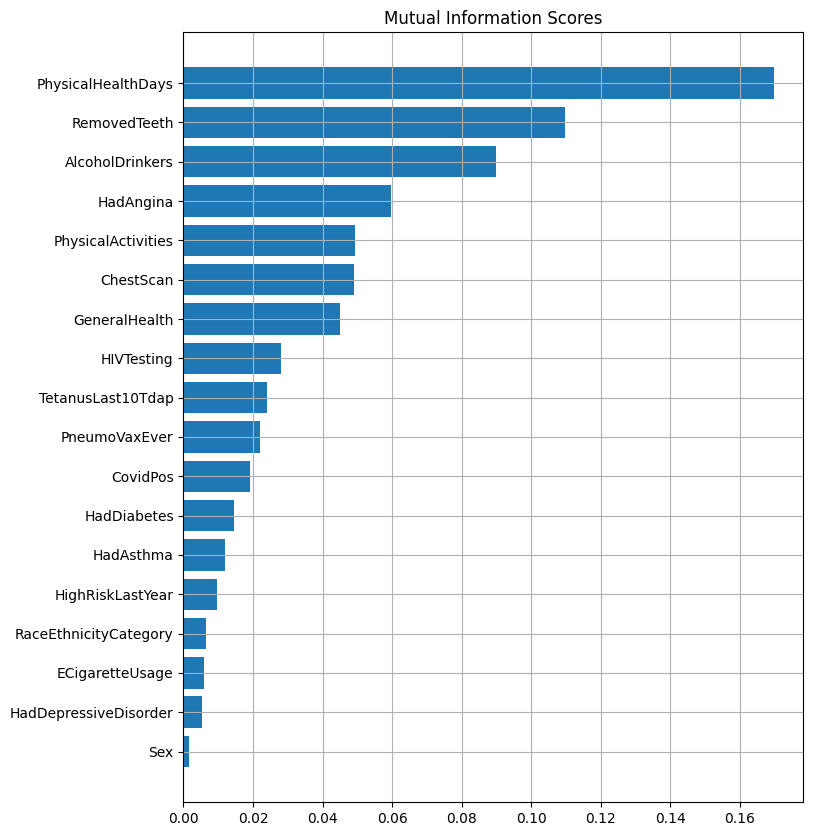

In [24]:
mi_scores = make_mi_scores(X_final, y_train)
print(mi_scores)
# print(mi_scores.tail(20))  # uncomment to see bottom 20
plt.style.use('default')
plt.figure(dpi=100, figsize=(8, 10))
plt.grid()
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [25]:
# # The "accuracy" scoring is proportional to the number of correct classifications
# clf_rf_4 = RandomForestClassifier(random_state=13)
# min_features_to_select = 10  # Minimum number of features to consider
# rfecv = RFECV(estimator=clf_rf_4,min_features_to_select=min_features_to_select, step=1, cv=cv,scoring='f1_macro')
# rfecv = rfecv.fit(X_train_scaled, y_train)

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train_scaled.columns[rfecv.support_])

In [26]:
# # Plot number of features VS. cross-validation scores
# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation 
# sns.set(font_scale = 1)
# plt.figure(figsize=(8,6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (F1 score)")
# plt.plot(
#     range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
#     rfecv.cv_results_['mean_test_score'],
# )
# plt.axhline(y=rfecv.cv_results_['mean_test_score'].max(), color='r', linestyle='dotted',alpha=1)
# plt.show()